In [1]:
import os, sys
import attr


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from PIL import Image
seaborn.set()

In [3]:
# add to path
sys.path.append("../..")
from filterflow.smc import SMC
from filterflow.base import State, Observation, InputsBase, StateSeries, FloatObservationSeries
from filterflow.observation.linear import LinearObservationModel
from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal.base import BootstrapProposalModel
from filterflow.resampling.criterion import NeffCriterion, AlwaysResample
from filterflow.resampling.standard.systematic import SystematicResampler
from filterflow.resampling.standard.multinomial import MultinomialResampler
from filterflow.resampling.base import NoResampling

# Define simple GHMM Data Generator

In [4]:
class GHMMOutput(object):
    __slots__ = ('observations', 'states')
    def __init__(self, observations: np.ndarray, states: np.ndarray):
        self.observations = observations
        self.states = states

# Definition of the dynamic model
class GHMM(object):
    def __init__(self, 
                 initial_state: np.ndarray,
                 transition_matrix: np.ndarray, 
                 transition_covariance: np.ndarray,
                 observation_matrix: np.ndarray,
                 observation_covariance: np.ndarray,
                 seed: int = None):
        """
        Construction method
        Parameters
        ----------

        """
        self.dim = initial_state.shape[0]
        self.initial_state = initial_state
                
        self.transition_matrix = transition_matrix
        self.transition_covariance = transition_covariance
        
        self.observation_matrix = observation_matrix
        self.observation_covariance = observation_covariance
        
        self.random_seed = seed
                
    def sample_latent_state(self, T):
        latent_state = self.initial_state
        random_samples =  np.random.multivariate_normal(np.repeat(0., self.dim), self.transition_covariance, T)
        
        latent_state_ts = []
        latent_state_ts.append(latent_state)
        for i, random_sample in enumerate(random_samples):
            latent_state = self.transition_matrix @ latent_state
            latent_state += random_sample
            latent_state_ts.append(latent_state)
        return np.array(latent_state_ts)
        
    def get_observation(self, latent_space_ts):
        T = latent_space_ts.shape[0]
        no_noise = np.einsum('ij,kj->ki', self.observation_matrix, latent_space_ts)
        return no_noise + np.random.multivariate_normal(np.repeat(0., self.dim), self.observation_covariance, T)
    
    def sample(self, N: int) -> GHMMOutput:
        """
        Samples n steps of the model
        Parameters
        ----------
        N: int
            total number of steps
        
        Returns
        -------
        ResonatorOutput from the parametrised process
        """
        latent_time_series = self.sample_latent_state(N)
        observations = self.get_observation(latent_time_series)
        return GHMMOutput(observations, latent_time_series)

## Specify linear dynamic

In [5]:
dim = 2
T = 150
initial_state          = np.repeat(0., dim)
transition_matrix      = np.eye(dim) * 0.5
transition_covariance  = np.eye(dim) * 0.5
observation_matrix     = np.eye(dim) *0.5
observation_covariance = np.eye(dim)*0.1

## Generate observations

In [6]:
linear_ss = GHMM(initial_state=initial_state, 
                 transition_matrix=transition_matrix,
                 transition_covariance=transition_covariance,
                 observation_matrix=observation_matrix,
                 observation_covariance=observation_covariance)

In [7]:
ghmm_output = linear_ss.sample(T)

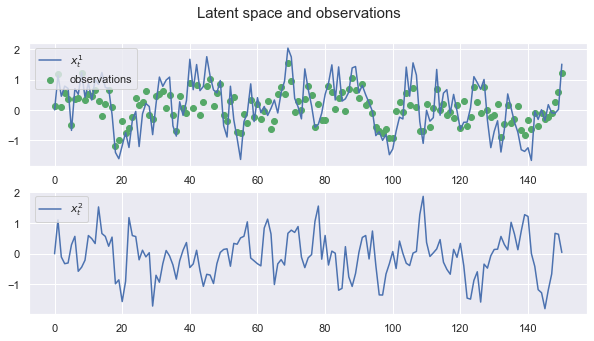

In [8]:

linspace  = np.arange(ghmm_output.observations[:,0].shape[0])
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
axes[0].scatter(linspace, ghmm_output.observations[:,0], marker='o', color='g', label='observations')
axes[0].plot(ghmm_output.states[:, 0], color='b', label='$x^1_t$')
axes[1].plot(ghmm_output.states[:, 1], color='b', label='$x^2_t$')
_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')
_ = fig.suptitle('Latent space and observations', fontsize=15)

## Specify Particle Filter Components

In [9]:
# store observations
batch_size = 1
n_particles = 1000
dimension = 2

In [10]:
observation_error = tfd.MultivariateNormalFullCovariance(np.array([0.,0.], dtype = np.float32),
                                                         linear_ss.observation_covariance.astype(np.float32))

observation_model = LinearObservationModel(tf.constant(linear_ss.observation_matrix.astype(np.float32)), observation_error)

W0408 16:51:12.120752 20032 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_probability\python\distributions\distribution.py:284: MultivariateNormalFullCovariance.__init__ (from tensorflow_probability.python.distributions.mvn_full_covariance) is deprecated and will be removed after 2019-12-01.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [11]:
transition_noise = tfd.MultivariateNormalFullCovariance(np.array([0., 0.], dtype=np.float32), 
                                                      linear_ss.transition_covariance.astype(np.float32))

transition_model = RandomWalkModel(tf.constant(linear_ss.transition_matrix.astype(np.float32)), 
                                   transition_noise)

proposal_model = BootstrapProposalModel(transition_model)

In [12]:
resampling_criterion = AlwaysResample()
resampling_method = MultinomialResampler()

In [13]:
particle_filter = SMC(observation_model, 
                                 transition_model, proposal_model, resampling_criterion, resampling_method)

In [14]:
observation_series = FloatObservationSeries(shape=[1, 1, 2])

for t, observation_value in enumerate(ghmm_output.observations):
    observation = Observation(tf.constant(np.array([[observation_value]], dtype=np.float32)))
    observation_series = observation_series.write(t, observation)

observation_series = observation_series.stack()

In [15]:
import time

weights = tf.ones((batch_size, n_particles), dtype= np.float32)/n_particles
initial_particles = tf.random.uniform((batch_size, n_particles, dim), -1, 1)
log_likelihoods = tf.zeros((batch_size), dtype=float)
initial_state = State(initial_particles, 
                      log_weights= tf.math.log(weights),
                      weights=weights, 
                      log_likelihoods=log_likelihoods)

In [35]:
record_states = particle_filter(initial_state, observation_series, True)
    

In [18]:
# compute states
computed_states = []
for t, _ in observation_series.enumerate():
    state = record_states.read(tf.cast(t, tf.dtypes.int32))
    log_weights = state.log_weights.numpy()
    particles = state.particles.numpy()[:,:,0]
    weights = np.exp(log_weights)
    computed_state = np.sum((weights * particles), axis=1)
    computed_states.append(computed_state)
    
computed_states = np.array(computed_states).flatten()

## Plot

In [19]:
import numpy as np
import bqplot.pyplot as bplt
from bqplot import LinearScale, Axis, Lines, Bars, Figure
axes_options = {'x': {'label': 't'}, 'y': {'label': 'y'}}
fig = bplt.figure(animation_duration=0)
lines = bplt.plot(
                x=np.linspace(0, len(ghmm_output.observations), len(ghmm_output.observations)), 
                y=ghmm_output.observations[:,0], 
                colors=['red'], 
                axes_options=axes_options)

if False:
    true_state_ln = bplt.plot(
                x=np.linspace(0, len(ghmm_output.observations), len(ghmm_output.observations)), 
                y=ghmm_output.states[:,0], 
                colors=['blue'], 
                axes_options=axes_options)

computed_lin = bplt.plot(
                x=np.linspace(0, len(ghmm_output.observations), len(ghmm_output.observations)), 
                y=computed_states, 
                colors=['green'], 
                axes_options=axes_options)

scatt = bplt.scatter([], [], colors=['blue'], axes_options=axes_options)


max_y = np.max([ghmm_output.observations[:,0]])
min_y = np.min([computed_states,ghmm_output.observations[:,0]])

bplt.set_lim(min_y-0.5, max_y+0.5, 'y')
bplt.set_lim(0, len(ghmm_output.observations), 'x')

fig

Figure(axes=[Axis(label='t', scale=LinearScale(max=151.0, min=0.0)), Axis(label='y', orientation='vertical', s…

FileNotFoundError: [Errno 2] No such file or directory: './gif_dir\\plot_0.png'

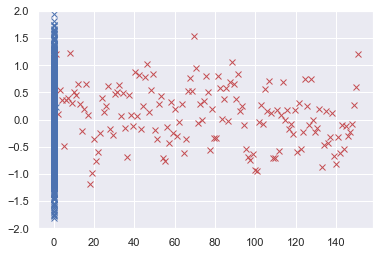

In [21]:
jitter = np.random.normal(0., 0.25, n_particles)

for t, _ in observation_series.enumerate():
    state = record_states.read(t)
    log_weights = state.log_weights.numpy()
    particles = state.particles.numpy()[0,:,0]
    weights = np.exp(log_weights)
    x = t + jitter
    y = particles
    
    plt.plot(np.linspace(0, len(ghmm_output.observations), len(ghmm_output.observations)), 
                     ghmm_output.observations[:,0], 'rx')

    computed_lin = plt.plot(np.linspace(0, t, t), 
                            computed_states[:t], 'g')
    plt.ylim(-2.,2.)
    plt.plot(x, y, 'bx')
    plt.savefig(os.path.join('./gif_dir','plot_{0}.png'.format(t)))
    plt.clf()
    

In [ ]:
fps = [os.path.join('./gif_dir', 'plot_{0}.png'.format(t)) for t in range(T+1)]

frames = [Image.open(fn) for fn in fps]

frames[0].save('pf.gif', format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)

![](pf.gif)

## Likelihood

In [22]:
final_state = record_states.read(150)

In [23]:
final_state.log_likelihoods

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-194.39124], dtype=float32)>

In [29]:
import tensorflow as tf
import tensorflow_probability as tfp

from filterflow.base import FloatStateSeries, State

batch_size = 1
n_particles = 1000
dimension = 2
rv = tfp.distributions.MultivariateNormalDiag([0., 0.], [1., 1.,])

In [30]:
initial_particles  = rv.sample(size = [batch_size, n_particles, dim])

In [31]:
# init state
state = attr.evolve(initial_state)

# infer dimensions and type
batch_size, n_particles, dimension = state.particles.shape
states = FloatStateSeries(batch_size=batch_size, n_particles=n_particles, dimension=dimension)

In [32]:
states.write(0,state)

FloatStateSeries(batch_size=1, n_particles=1000, dimension=2, particles=<tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x000001E03FC29EF0>, log_weights=<tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x000001E03FC29CF8>, weights=<tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x000001E03FC7DC18>, log_likelihoods=<tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x000001E03FC7DA90>)

In [33]:
obs = observation_series.read(0)
particle_filter.update(state, obs, None)

AttributeError: 'MapDataset' object has no attribute 'read'

In [ ]:
class TestStateSeries(tf.test.TestCase):
    def setUp(self):
        tf.random.set_seed(42)
        self.particles = tf.zeros([4, 10000, 3])
        self.rv = tfp.distributions.MultivariateNormalDiag([0., 0., 0.], [1., 1., 1.])
        self.transition_matrix = tf.eye(3) * 0.
        self.model = RandomWalkModel(self.transition_matrix, self.rv)

    def test_statecomparison(self, state1, state2):
        self.assertAllEqual(state1.particles, state2.particles)
        self.assertAllEqual(state1.log_likelihoods, state2.log_likelihoods)
        self.assertAllEqual(state1.log_weights, state2.log_weights)

    def test_sample(self):
        sample = self.model.sample(MockState(self.particles), None)
        self.assertAllEqual(sample.shape,
                            self.particles.shape.as_list())
        self.assertAllClose(tf.math.reduce_std(sample, [1]), [[1.] * 3] * 4, atol=1e-2)